### Libraries

In [49]:
import time
import math
import shap
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score, confusion_matrix, classification_report

### Dataset

In [2]:
df = pd.DataFrame(pd.read_csv("global.csv"))
display(df.shape)
df.head(3)

(56223, 127)

,name,year,vs0,PSLV_v2,PSLV_v3,PSLV_v4,PSLV_v5,PSLV_v6,PSLV_v7,PSLV_v8,...,O700_t24,CFLX_t24,CSST_t24,V20C_t24,E000_t24,DELV-12,date,hour,date-time,dvs24
0,EP011982,1982,25,546,-20.0,10.0,-28.0,22.0,-23.0,20.0,...,-50.0,56.0,293.0,77.0,3511.0,0.786585,20-05-1982,00:00:00,20-05-1982 00:00,5.004258
1,EP011982,1982,25,621,-15.0,10.0,-31.0,21.0,-21.0,19.0,...,-58.0,53.0,293.0,67.0,3503.0,0.786585,20-05-1982,06:00:00,20-05-1982 06:00,5.004258
2,EP011982,1982,25,567,-20.0,10.0,-21.0,18.0,-20.0,17.0,...,-7.0,69.0,293.0,64.0,3497.0,0.000000,20-05-1982,12:00:00,20-05-1982 12:00,5.004258


In [3]:
#dropping the unnecessary columns
df.drop(columns = ['date', 'hour', 'date-time'], axis = 1, inplace = True)
display(df.shape)
df.head(3)

(56223, 124)

,name,year,vs0,PSLV_v2,PSLV_v3,PSLV_v4,PSLV_v5,PSLV_v6,PSLV_v7,PSLV_v8,...,HE07_t24,HE05_t24,O500_t24,O700_t24,CFLX_t24,CSST_t24,V20C_t24,E000_t24,DELV-12,dvs24
0,EP011982,1982,25,546,-20.0,10.0,-28.0,22.0,-23.0,20.0,...,12.0,14.0,-67.0,-50.0,56.0,293.0,77.0,3511.0,0.786585,5.004258
1,EP011982,1982,25,621,-15.0,10.0,-31.0,21.0,-21.0,19.0,...,30.0,50.0,-69.0,-58.0,53.0,293.0,67.0,3503.0,0.786585,5.004258
2,EP011982,1982,25,567,-20.0,10.0,-21.0,18.0,-20.0,17.0,...,27.0,43.0,-11.0,-7.0,69.0,293.0,64.0,3497.0,0.000000,5.004258


In [5]:
#create a list of all features
# Target is dvs24
feat = df.columns.to_list()
len(feat)

124

In [6]:
# Select a basin to run the model

select_basin = str(input('Select ocean basin: '))

# Dictionary of cell range index of the basins
basins = {
    'Western Pacific': '26616:44660',
    'Atlantic': '44660:55370',
    'Indian': '13399:15778',
    'Eastern Pacific': '0:13397'
}

if select_basin not in basins:
    raise ValueError("Invalid basin selection!")

# Extracting start and end indices from the dictionary based on the selected basin
start_idx, end_idx = map(int, basins[select_basin].split(':'))

Select ocean basin: Indian


In [7]:
df1 = df.iloc[start_idx : end_idx][feat]
print("Selected basin:", select_basin)
df1.head()

Selected basin: Indian


,name,year,vs0,PSLV_v2,PSLV_v3,PSLV_v4,PSLV_v5,PSLV_v6,PSLV_v7,PSLV_v8,...,HE07_t24,HE05_t24,O500_t24,O700_t24,CFLX_t24,CSST_t24,V20C_t24,E000_t24,DELV-12,dvs24
13399,IO021990,1990,30,476,-25.0,5.0,-10.0,8.0,-14.0,6.0,...,-12.0,-20.0,-143.0,-116.0,52.0,300.0,67.0,3564.0,5.004258,15.012775
13400,IO021990,1990,35,484,-28.0,15.0,-13.0,6.0,-17.0,8.0,...,-19.0,-17.0,-170.0,-150.0,23.0,300.0,81.0,3571.0,10.008517,15.012775
13401,IO021990,1990,35,494,-23.0,18.0,-11.0,5.0,-15.0,10.0,...,-18.0,-11.0,-130.0,-101.0,-9.0,300.0,106.0,3582.0,5.004258,20.017033
13402,IO021990,1990,40,543,-18.0,13.0,-15.0,10.0,-15.0,11.0,...,-17.0,-16.0,-173.0,-144.0,48.0,301.0,85.0,3572.0,5.004258,20.017033
13403,IO021990,1990,45,556,-20.0,5.0,-16.0,13.0,-17.0,9.0,...,-3.0,-8.0,-160.0,-127.0,46.0,301.0,123.0,3564.0,10.008517,25.021292


In [8]:
display(f'Range of years: {df1["year"].min()} - {df1["year"].max()}')
display(df1.shape)

'Range of years: 1990 - 2017'

(2379, 124)

In [9]:
# list of input features + target (use this variable in place of best_feat IF you want to use all 121 features)
all_feat = feat[2 :]

### Leave-three-year-out cross validation folds 

In [10]:
years = df1['year'].unique()  # Get unique years from the 'year' column

train_test_data = []  # List to store training and testing datasets

for i in range(0, len(years) - 2, 3):  # Loop over the range up to len(years) - 2
    test_years = years[i : i + 3]      # Three consecutive years as testing years
    train_years = np.setdiff1d(years, test_years)  # All other years as training years

    train_data = df1[df1['year'].isin(train_years)]  # Training data 
    test_data = df1[df1['year'].isin(test_years)]    # Testing data             

    train_data = train_data.drop(['name', 'year'], axis = 1)  
    test_data = test_data.drop(['name', 'year'], axis = 1)
    
    train_test_data.append((train_data, test_data))

### Pipleine for Feature selection/ranking 

In [11]:
def populate_train_test(train_test_data, all_feat):
    """
    Function to populate the train and test data
    """
    
    X_train_list, y_train_list, X_test_list, y_test_list = [], [], [], []

    for train_data, test_data in train_test_data:
        X_train = train_data[all_feat].drop(columns = 'dvs24').values
        y_train = train_data['dvs24'].values
        X_test = test_data[all_feat].drop(columns = 'dvs24').values
        y_test = test_data['dvs24'].values

        X_train_list.append(X_train)
        y_train_list.append(y_train)
        X_test_list.append(X_test)
        y_test_list.append(y_test)

    return X_train_list, y_train_list, X_test_list, y_test_list

In [12]:
def process_data(X_train, y_train, X_test, y_test):
    """
    Function to process the data (scaling, encoding, and oversampling)
    """
    
    # Feature scaling and target encoding
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    y_train = np.where(y_train >= 30, 1, 0)
    X_test_scaled = scaler.transform(X_test) 
    y_test = np.where(y_test >= 30, 1, 0)

    unri = np.where(y_train < 1)
    ri = np.where(y_train > 0)
    a, b = y_train[unri], y_train[ri]  # Computing the no. of RI and UNRI cases
    
    # SMOTE oversampling
    sm = SMOTE(random_state = 42,
               k_neighbors = 10,
               sampling_strategy = {0: len(a), 1: round(0.60 * len(a))})
    X_train_resampled, y_train_resampled = sm.fit_resample(X_train_scaled, y_train)

    return X_train_resampled, y_train_resampled, X_test_scaled, y_test

In [13]:
def train_and_evaluate(X_train, y_train, X_test, y_test):
    """
    Function to train the model and evaluate performance
    """
    
    if select_basin == 'Atlantic':
        svc = SVC(kernel = 'rbf', gamma = 0.001, C = 15, verbose = False)
    elif select_basin == 'Indian':
        svc = SVC(kernel = 'rbf', gamma = 0.0005, C = 5, verbose = False)
    elif select_basin == 'Western Pacific':
        svc = SVC(kernel = 'rbf', gamma = 'auto', C = 1, verbose = False)
    elif select_basin == 'Eastern Pacific':
        svc = SVC(kernel = 'rbf', gamma = 'auto', C = 1, verbose = False)
        
    classifier = svc.fit(X_train, y_train)
    y_predict = classifier.predict(X_test)

    f1 = f1_score(y_test, y_predict, zero_division = 0)
    cm = confusion_matrix(y_test, y_predict)
    tp, tn, fp, fn = cm[1, 1], cm[0, 0], cm[0, 1], cm[1, 0]
    pod = tp / (tp + fn)
    far = fp / (tp + fp)

    return classifier, f1, pod, far

In [14]:
def permutation(X_train, y_train, classifier):
    """
    Function to compute permutation feature importance scores
    """
    
    perm = permutation_importance(classifier, X_train, y_train,
                                  n_repeats = 5, scoring = 'f1',
                                  random_state = 42, n_jobs = 6)
    perm_importances = perm.importances_mean
    
    return perm_importances

In [43]:
def rf_ranking(X_train, y_train, classifier):
    """
    Function to compute random forest feature rankings
    """
    
    rf = RandomForestClassifier(n_estimators = 200, random_state = 42)
    rf.fit(X_train, y_train)
    rf_importances = rf.feature_importances_
    
    return rf_importances

### Running the pipeline for Permutation feature importance method

In [44]:
def run_permutation_model(train_test_data, all_feat):
    """
    Function to run the pipleine for PI method
    """
    
    list_f1, list_pod, list_far = [], [], []
    list_perm_importances = []

    for i, (X_train, y_train, X_test, y_test) in enumerate(zip(*populate_train_test(train_test_data, all_feat))):
        
        X_train_resampled, y_train_resampled, X_test_scaled, y_test = process_data(X_train, y_train, X_test, y_test)
        
        classifier, f1, pod, far = train_and_evaluate(X_train_resampled, y_train_resampled, X_test_scaled, y_test)
        
        list_f1.append(f1)
        list_pod.append(pod)
        list_far.append(far)
        print(f'Fold #{i + 1} F1 {f1} POD {pod} FAR {far}')

        # PI function call
        perm_importances = permutation(X_train_resampled, y_train_resampled, classifier)
        list_perm_importances.append(perm_importances)

    avg_f1 = sum(list_f1) / len(list_f1)
    avg_perm_importances = np.mean(list_perm_importances, axis = 0)

    print('\nAverage F1 score across all folds:', avg_f1)
    print('\nAverage Permutation Importances:', avg_perm_importances)
    
    return list_perm_importances, avg_perm_importances

In [16]:
start = time.time()

list_perm_importances, avg_perm_importances = run_permutation_model(train_test_data, all_feat)

end = time.time()
print('\nTime elapsed:', (end - start) / 60, 'min')

Fold #1 F1 0.3157894736842105 POD 1.0 FAR 0.8125
Fold #2 F1 0.3529411764705882 POD 0.42857142857142855 FAR 0.7
Fold #3 F1 0.12000000000000002 POD 0.16666666666666666 FAR 0.90625
Fold #4 F1 0.6557377049180327 POD 0.7692307692307693 FAR 0.42857142857142855
Fold #5 F1 0.0 POD 0.0 FAR 1.0
Fold #6 F1 0.6923076923076924 POD 1.0 FAR 0.47058823529411764
Fold #7 F1 0.5333333333333333 POD 0.5714285714285714 FAR 0.5
Fold #8 F1 0.37037037037037035 POD 0.7142857142857143 FAR 0.75
Fold #9 F1 0.3921568627450981 POD 0.5882352941176471 FAR 0.7058823529411765

Average F1 score across all folds: 0.38140406820325834

Average Permutation Importances: [ 1.18610434e-02  4.99879353e-04  6.41142409e-04  1.21294031e-03
 -2.28408668e-04 -5.30196060e-04 -2.08205654e-05 -6.49645206e-04
  0.00000000e+00  2.43111915e-04  9.60694446e-05  4.66524025e-04
  9.55931936e-04  2.67869060e-03  1.46461578e-04  4.68189032e-04
  4.84507829e-04 -2.31457505e-04  8.78121927e-04  3.82286825e-03
  2.50163535e-03 -7.59704045e-04 -1.3

### Visualization of results from PI 

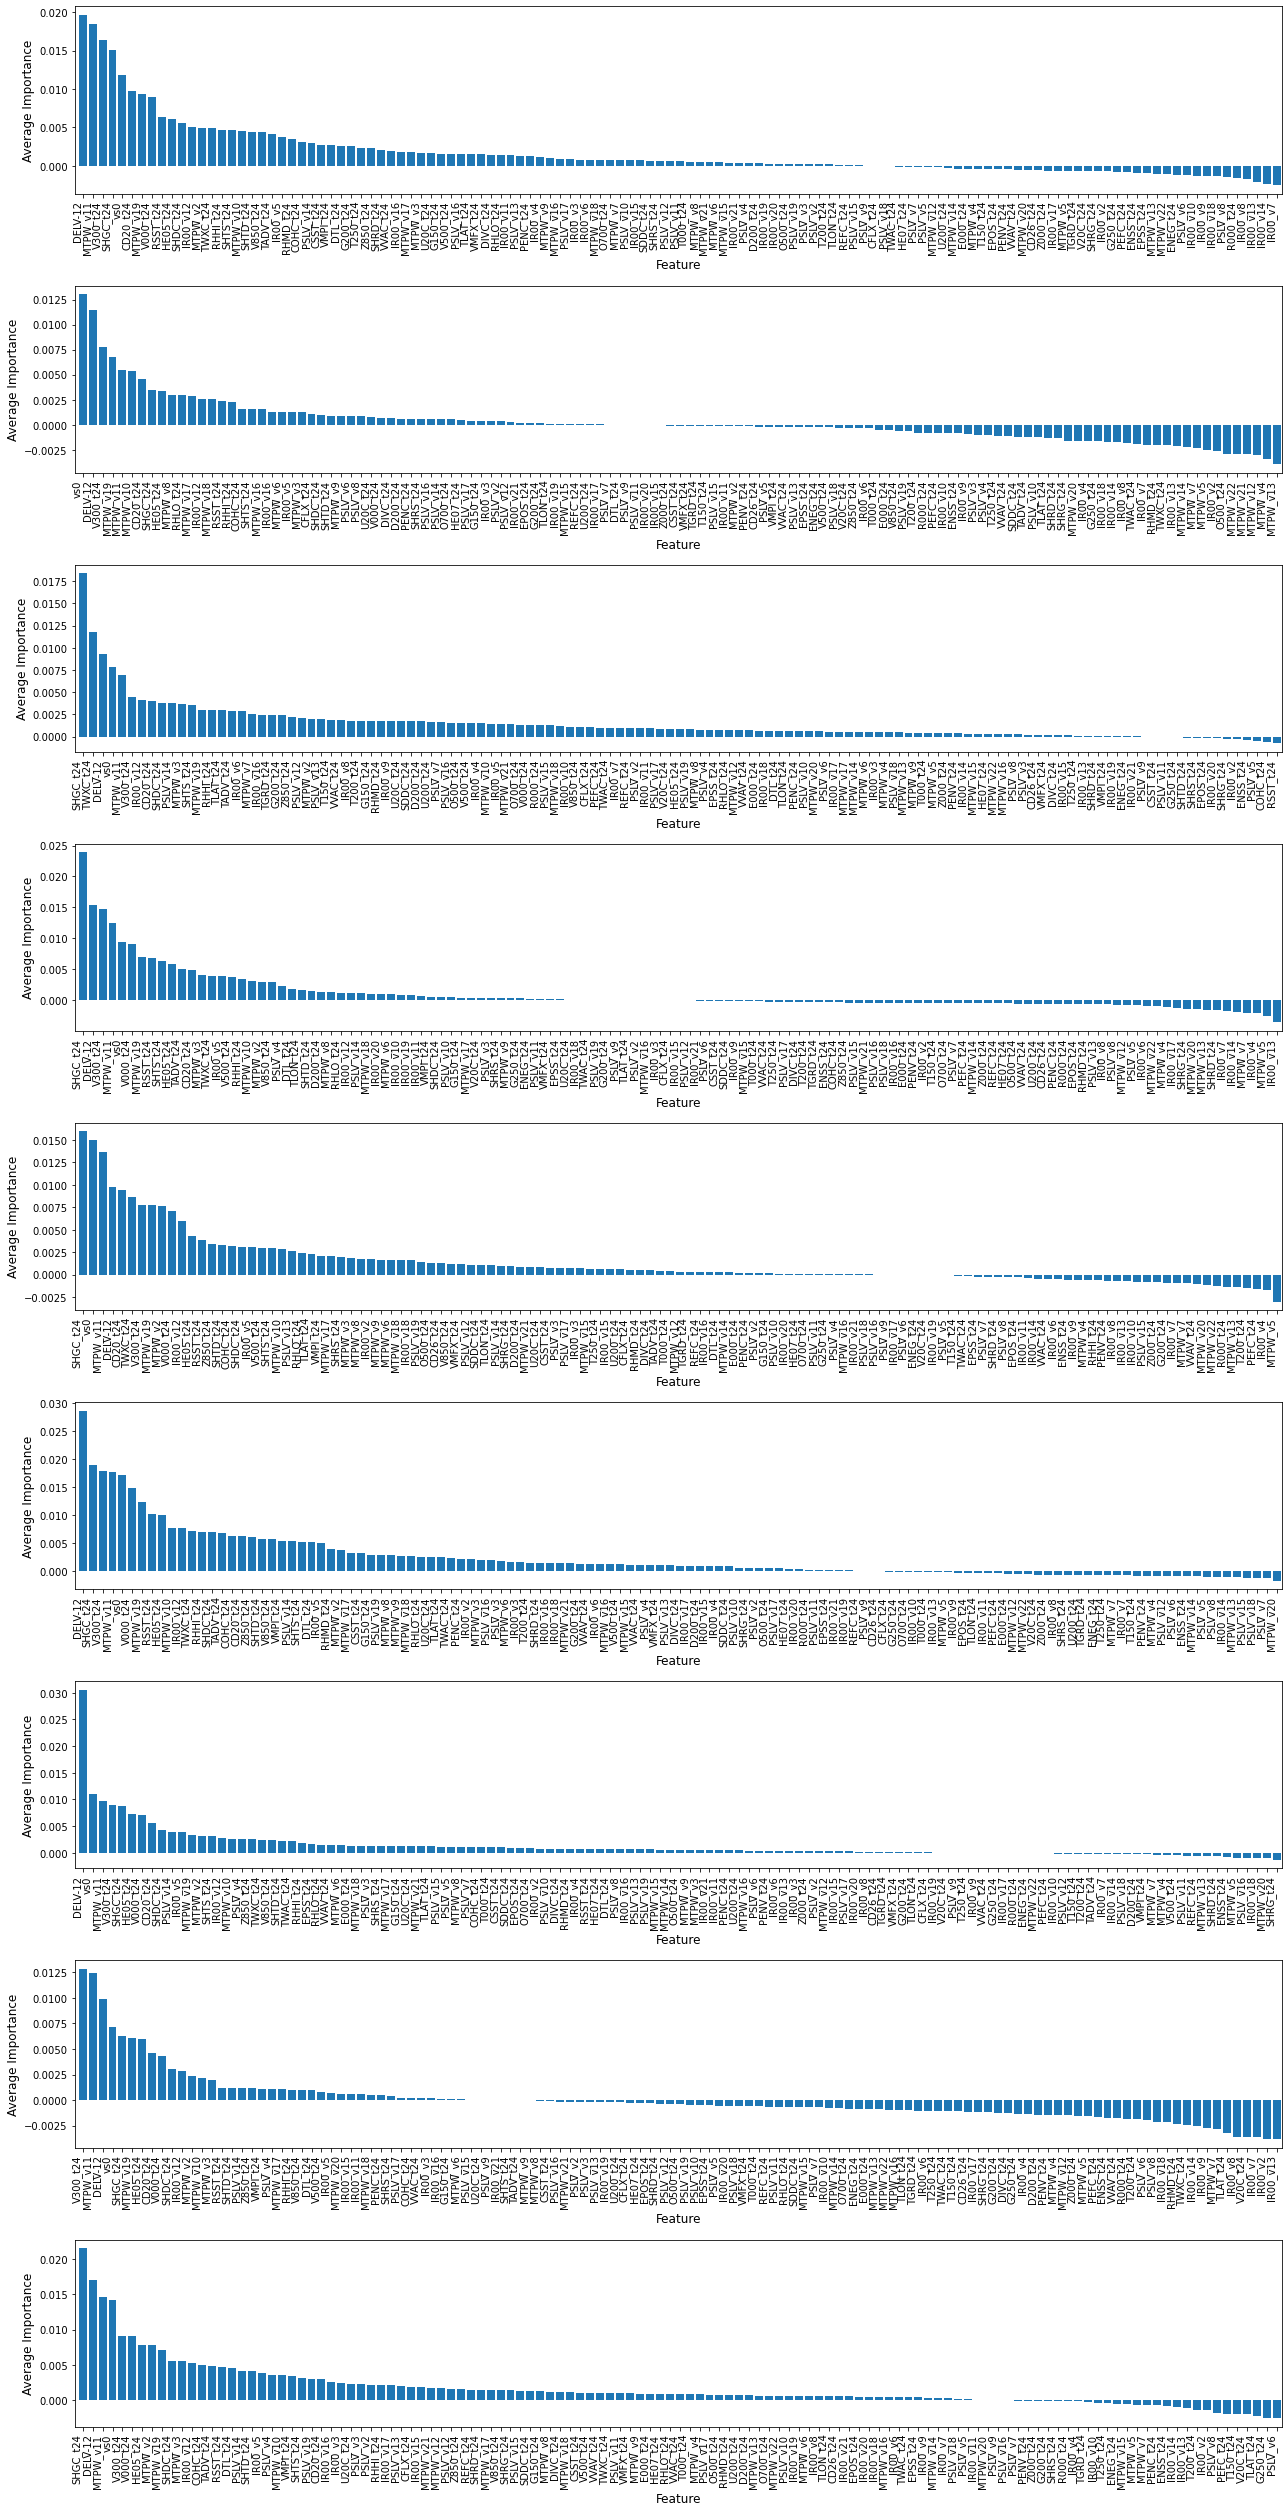

In [17]:
# Permutation feature importance in each CV fold

arr_perm_importances = np.array(list_perm_importances)
folds = len(train_test_data)

fig, ax = plt.subplots(folds 1, figsize = (18, 35))
for i in range(folds):  
    importance_array = arr_perm_importances[i]
    sorted_index = np.argsort(importance_array)[::-1]
    sorted_importances = importance_array[sorted_index]
    ax[i].bar(range(len(all_feat) - 1), sorted_importances, tick_label = np.array(all_feat[:-1])[sorted_index])
    ax[i].set_xlabel('Feature', fontsize = 12)
    ax[i].set_ylabel('Average Importance', fontsize = 12)
    ax[i].set_xticklabels(np.array(all_feat[:-1])[sorted_index], rotation = 90, ha = 'right')
    ax[i].set_xlim(-0.8, len(all_feat) - 1 - 0.5)

plt.tight_layout()
plt.show()

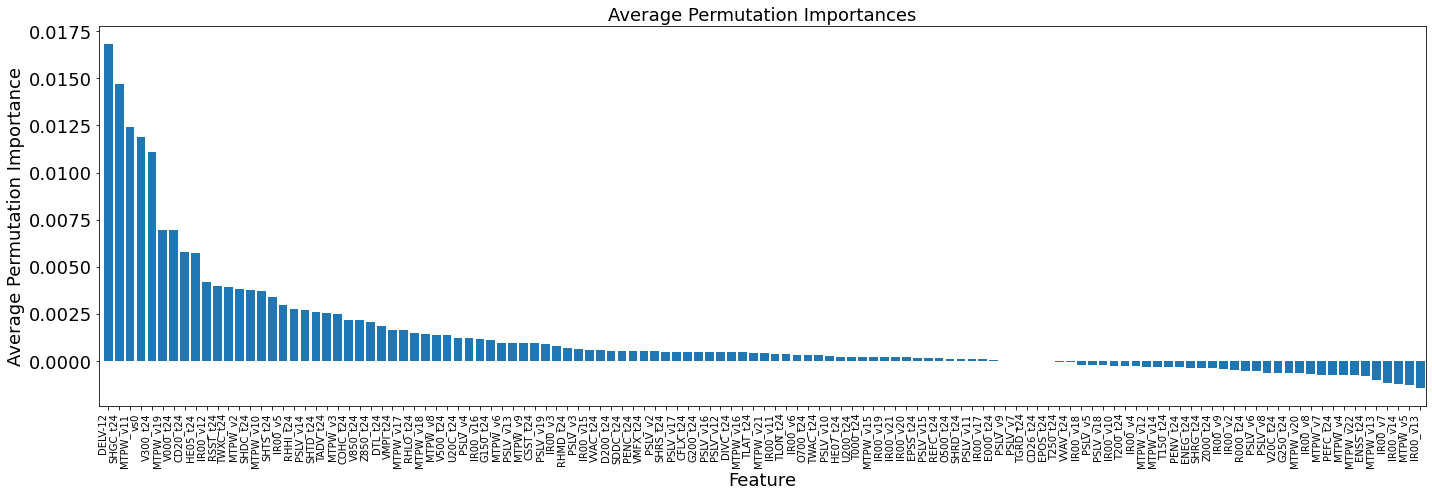

In [18]:
# Average permutation importances

sorted_indices = np.argsort(avg_perm_importances)[::-1]         # Indices after sorting in descending order
sorted_perm_importances = avg_perm_importances[sorted_indices]  # Corresponding feature names

plt.figure(figsize = (20, 7))
plt.bar(range(len(all_feat) - 1), sorted_perm_importances, tick_label = np.array(all_feat[:-1])[sorted_indices])
plt.xlabel('Feature', fontsize = 18)
plt.ylabel('Average Permutation Importance', fontsize = 18)
plt.title('Average Permutation Importances', fontsize = 18)
plt.xticks(rotation = 90, ha = 'right')
plt.yticks(fontsize = 18)
plt.xlim(-0.8, len(all_feat) - 1 - 0.5)
plt.tight_layout()
plt.show()

### CSV export of selected features

In [40]:
# Adjust `n` to select the number of features to retain from the total.
n = 30
best_n_perm_features = list(np.array(all_feat[:-1])[sorted_indices][: n])
df_n_perm = pd.Series(best_n_perm_features)
best_n_perm = df_n_perm.to_csv('best_30_perm_indian.csv')   # change the name according to `n` and basin
best_n_perm

### Running the pipeline for Random Forest ranking method

In [45]:
def run_rf_model(train_test_data, all_feat):
    """
    Function to run the pipeline for RF ranking method
    """
    
    list_f1, list_pod, list_far = [], [], []
    list_rf_importances = []

    for i, (X_train, y_train, X_test, y_test) in enumerate(zip(*populate_train_test(train_test_data, all_feat))):
        
        X_train_resampled, y_train_resampled, X_test_scaled, y_test = process_data(X_train, y_train, X_test, y_test)
        
        classifier, f1, pod, far = train_and_evaluate(X_train_resampled, y_train_resampled, X_test_scaled, y_test) 
        
        list_f1.append(f1)
        list_pod.append(pod)
        list_far.append(far)
        print(f'Fold #{i + 1} F1 {f1} POD {pod} FAR {far}')
        
        # RF ranking function call
        rf_importances = rf_ranking(X_train_resampled, y_train_resampled, classifier)
        list_rf_importances.append(rf_importances)

    avg_rf_importances = np.mean(list_rf_importances, axis = 0)
    
    avg_f1 = sum(list_f1) / len(list_f1)
    print('\nAverage F1 score across all folds:', avg_f1)
    print('\nAverage Permutation Importances:', avg_rf_importances)

    return list_rf_importances, avg_rf_importances

In [46]:
start = time.time()

list_rf_importances, avg_rf_importances = run_rf_model(train_test_data, all_feat)

end = time.time()
print('\nTime elapsed:', (end - start) / 60, 'min')

Fold #1 F1 0.3157894736842105 POD 1.0 FAR 0.8125
Fold #2 F1 0.3529411764705882 POD 0.42857142857142855 FAR 0.7
Fold #3 F1 0.12000000000000002 POD 0.16666666666666666 FAR 0.90625
Fold #4 F1 0.6557377049180327 POD 0.7692307692307693 FAR 0.42857142857142855
Fold #5 F1 0.0 POD 0.0 FAR 1.0
Fold #6 F1 0.6923076923076924 POD 1.0 FAR 0.47058823529411764
Fold #7 F1 0.5333333333333333 POD 0.5714285714285714 FAR 0.5
Fold #8 F1 0.37037037037037035 POD 0.7142857142857143 FAR 0.75
Fold #9 F1 0.3921568627450981 POD 0.5882352941176471 FAR 0.7058823529411765

Average F1 score across all folds: 0.38140406820325834

Average Permutation Importances: [0.02788118 0.00377803 0.00399158 0.00359007 0.00395832 0.0053897
 0.00438709 0.00427682 0.         0.00544324 0.00523508 0.00394256
 0.0058965  0.0057047  0.00204884 0.00318474 0.00312578 0.0024441
 0.0033308  0.00430302 0.00428292 0.00616192 0.00335851 0.00442684
 0.00228566 0.00906871 0.00442716 0.01673137 0.0098548  0.00619805
 0.00329878 0.00626603 0.0025

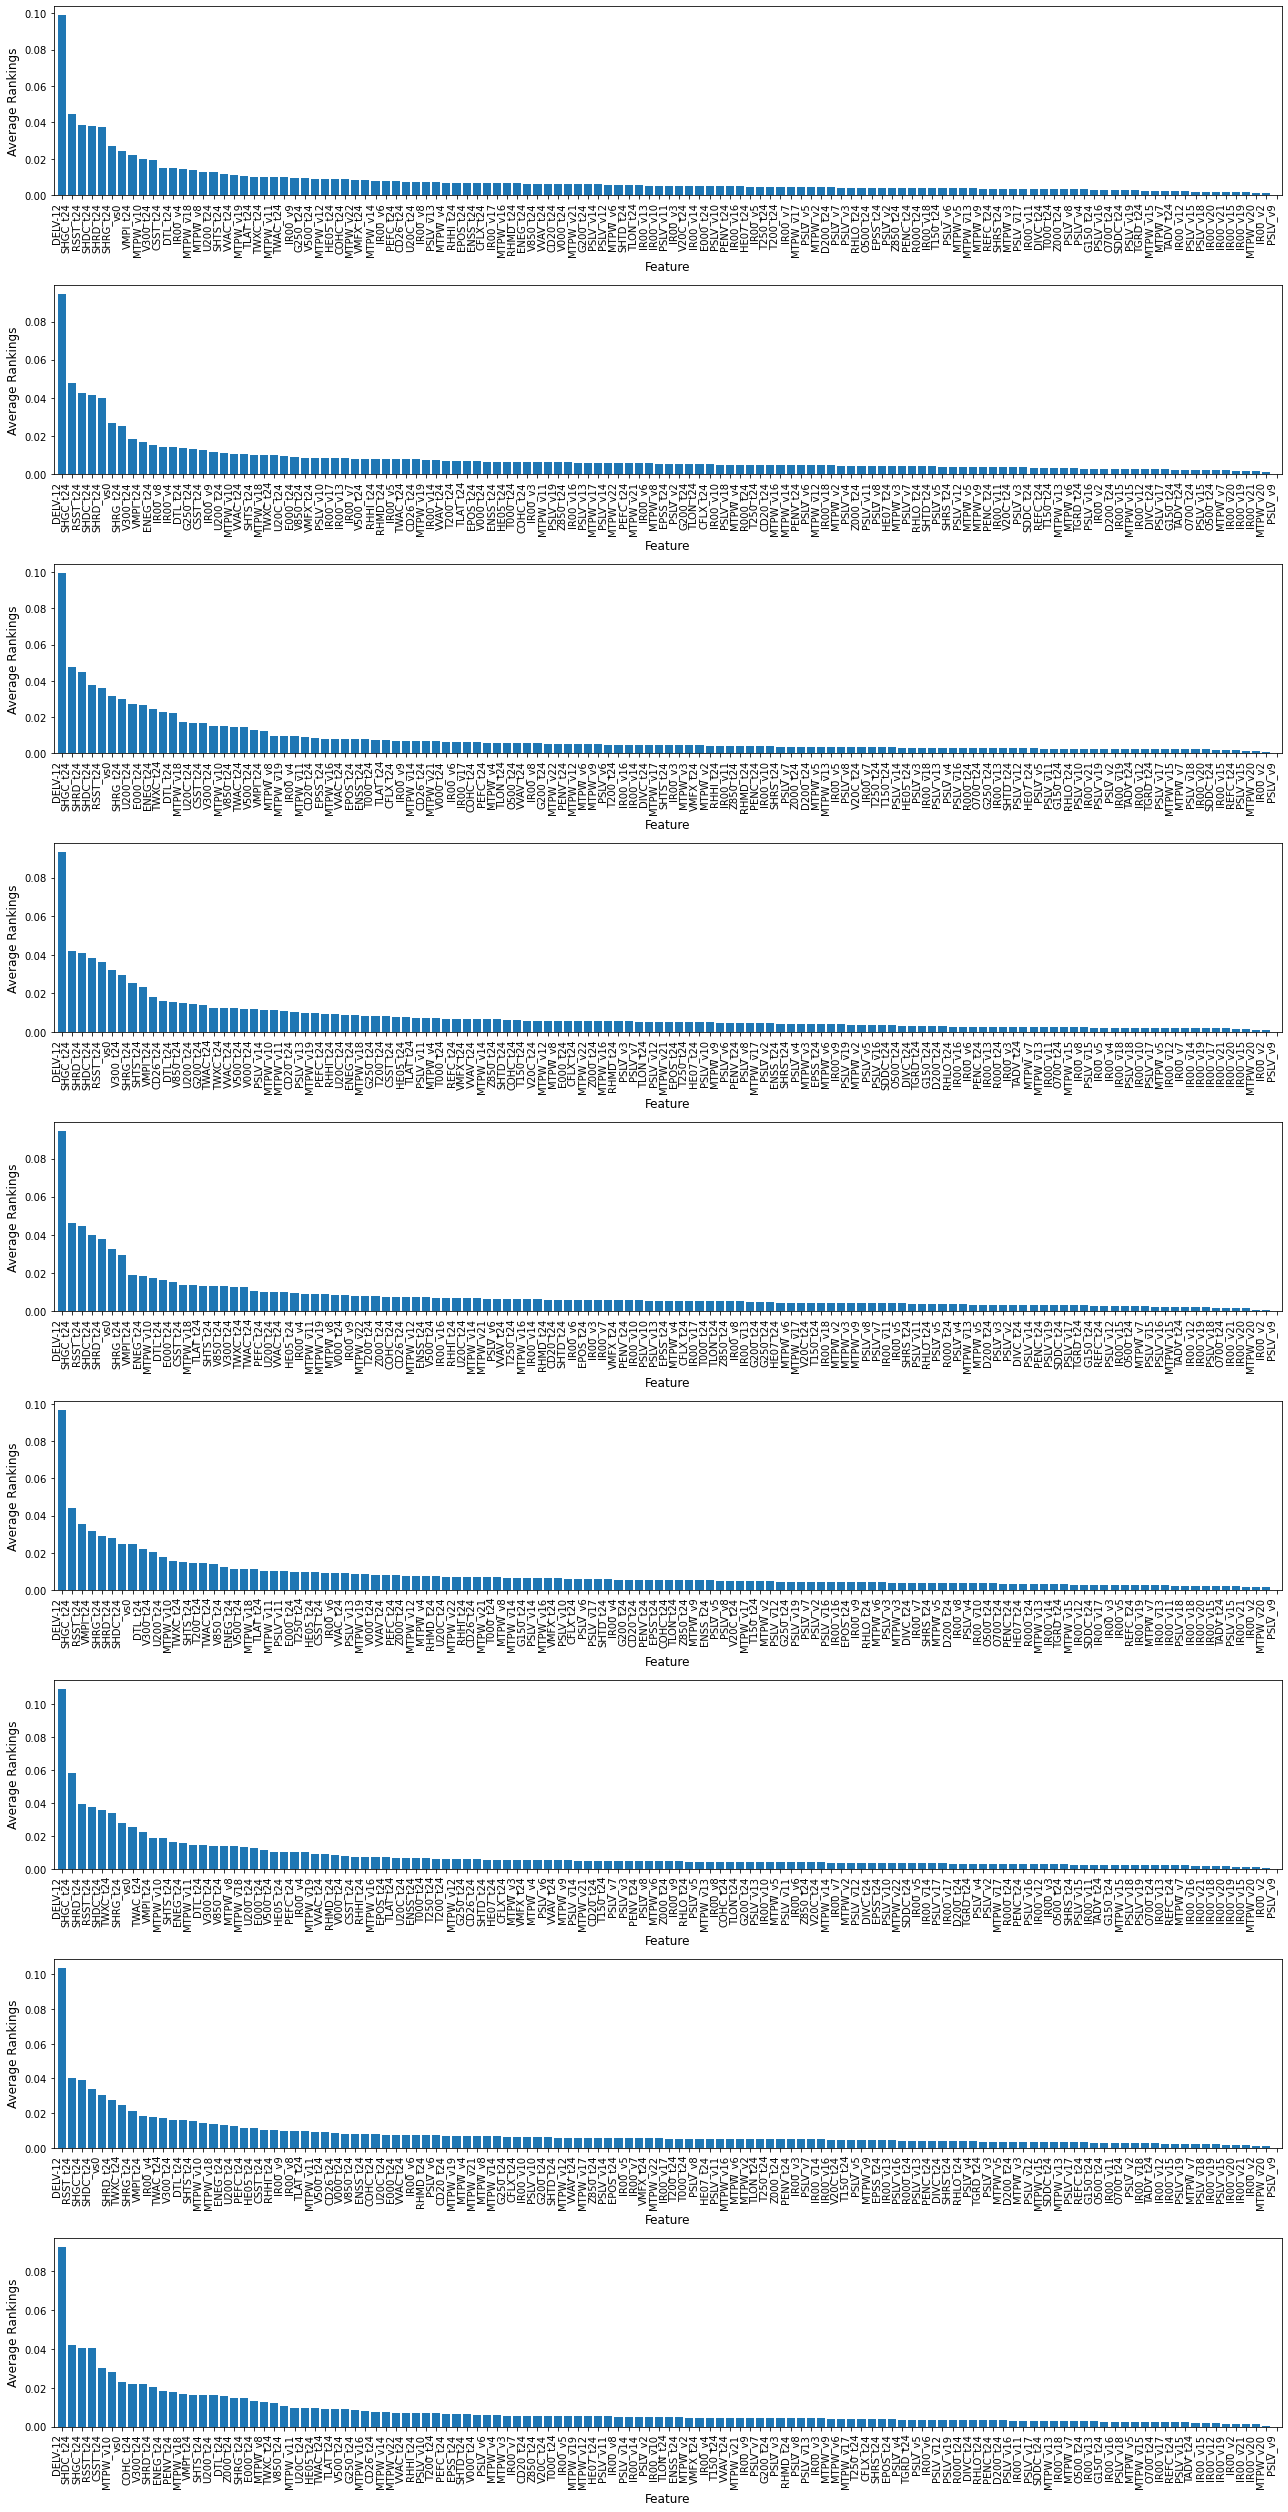

In [47]:
# Random forest rankings in each CV fold

arr_rf_importances = np.array(list_rf_importances)
folds = len(train_test_data)

fig, ax = plt.subplots(folds, 1, figsize = (18, 35))
for i in range(folds):  
    rankings_array_rf = arr_rf_importances[i]
    sorted_index_rf = np.argsort(rankings_array_rf)[::-1]
    sorted_rankings = rankings_array_rf[sorted_index_rf]
    ax[i].bar(range(len(all_feat) - 1), sorted_rankings, tick_label = np.array(all_feat[:-1])[sorted_index_rf])
    ax[i].set_xlabel('Feature', fontsize = 12)
    ax[i].set_ylabel('Average Rankings', fontsize = 12)
    ax[i].set_xticklabels(np.array(all_feat[:-1])[sorted_index_rf], rotation = 90, ha = 'right')
    ax[i].set_xlim(-0.8, len(all_feat) - 1 - 0.5)

plt.tight_layout()
plt.show()

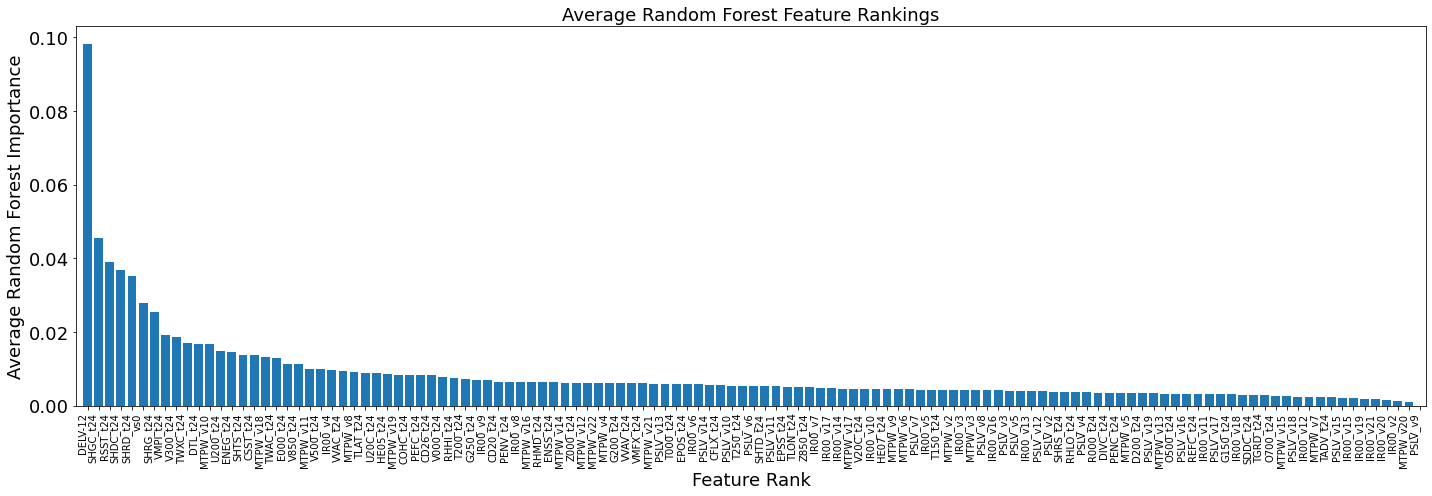

In [48]:
# Average Random Forest feature rankings

feature_ranking_indices = np.argsort(avg_rf_importances)[::-1]             # Indices after sorting in descending order
feature_ranking_names = np.array(all_feat[:-1])[feature_ranking_indices]   # Corresponding feature names

plt.figure(figsize = (20, 7))
plt.bar(range(len(feature_ranking_names)), avg_rf_importances[feature_ranking_indices])
plt.xlabel('Feature Rank', fontsize = 18)
plt.ylabel('Average Random Forest Importance', fontsize = 18)
plt.title('Average Random Forest Feature Rankings', fontsize = 18)
plt.xticks(range(len(feature_ranking_names)), feature_ranking_names, rotation = 90, ha = 'right')
plt.yticks(fontsize = 18)
plt.xlim(-1, len(all_feat) - 1 - 0.5)
plt.tight_layout()
plt.show()

### CSV export of selected features

In [42]:
# Adjust `n` to select the number of features to retain from the total.
n = 30
best_n_rf_features = list(np.array(all_feat[:-1])[feature_ranking_indices][: n])
df_n_rf = pd.Series(best_n_rf_features)
best_n_rf = df_n_rf.to_csv('best_30_rf_indian.csv')     # change the name according to `n` and basin
best_n_rf